<a href="https://colab.research.google.com/github/PinaColadast/CDR3_prediction_case/blob/main/deepCDR_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
pip install logomaker

In [3]:
#import library
import sys
import os
import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import logomaker


from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D
from keras import backend as K
from keras.models import Sequential, load_model


from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
##read the files 
df_path_1 = "/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_variants_binding_488.csv"
df1 = pd.read_csv(df_path_1, index_col = 0)
df_path_1 = "/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_variants_binding_647.csv"
df2 = pd.read_csv(df_path_1, index_col = 0)

In [5]:
binding = glob.glob("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1*_binding*.csv")
df_binding= pd.concat([pd.read_csv(f, sep= ",", header=0, index_col=0) for f in binding])
df_non_binding = pd.read_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_variants_nonbinding.csv",
                             index_col = 0)
df_ex_test = pd.read_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_variants_test.csv",
                         index_col = 0)

#check data quality 
in the context of sequecing, check Q score and P score 
setting quality threshold of Q score: 25

Entries with Q <= 25 are excluded

take minimum value of Q score across an actual sequence


In [6]:
def Q_score(ACSII_sequence):
  Q_score = [ord(i)-33 for i in ACSII_sequence]
  return Q_score 

def P_score(ACSII_sequence):
  P_score = [10**-((ord(i)-33)/10) for i in ACSII_sequence]
  return P_score

def SequenceFrequencyCreator(df_sequence):
    aa_list = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H',
           'R', 'N', 'D', 'T']
    cnt_matrix = np.zeros((15, 20))
    dict_sequence = dict(zip(df_sequence.index, df_sequence["CloneCount"]))
    for i in df_sequence.index:
    # print(i)
      for j,k in enumerate(i):
        # print(j,k)
          cnt_matrix[j, aa_list.index(k)] += 1*dict_sequence[i]
    
    df_freq = pd.DataFrame(cnt_matrix/cnt_matrix.sum(axis=1)[:, np.newaxis], index = range(0,15), columns = aa_list)
    return df_freq
  


df1["Q_score"] = df1.copy().apply(lambda row: Q_score(row["SequencingQuality"]), axis =1)
df2["Q_score"] = df2.copy().apply(lambda row: Q_score(row["SequencingQuality"]), axis =1)
df_non_binding["Q_score"]= df_non_binding.copy().apply(lambda row: Q_score(row["SequencingQuality"]), axis =1)

df1["P_score"] = df1.copy().apply(lambda row: P_score(row["SequencingQuality"]), axis =1)
df2["P_score"] = df2.copy().apply(lambda row: P_score(row["SequencingQuality"]), axis =1)
df_non_binding["P_score"]= df_non_binding.copy().apply(lambda row: P_score(row["SequencingQuality"]), axis =1)


df1["max_P_score"] = df1.copy().apply(lambda row: max(row["P_score"]), axis = 1)
df2["max_P_score"] = df2.copy().apply(lambda row: max(row["P_score"]), axis = 1)
df_non_binding["max_P_score"]= df_non_binding.copy().apply(lambda row: max(row["P_score"]), axis = 1)


df1["min_Q_score"] = df1.copy().apply(lambda row: min(row["Q_score"]), axis = 1)
df2["min_Q_score"] = df2.copy().apply(lambda row: min(row["Q_score"]), axis = 1)
df_non_binding["min_Q_score"]= df_non_binding.copy().apply(lambda row: min(row["Q_score"]), axis = 1)

##Filter data by Q score


In [7]:
df_binding = pd.concat([df1, df2])
df_highqua_bd = df_binding.loc[df_binding["min_Q_score"] >= 25]
df_sequence_bd = df_highqua_bd.groupby("AminoAcidSequence_CDR3").sum()
df_freq_bd = SequenceFrequencyCreator(df_sequence_bd)


df_highqua_nbd = df_non_binding.loc[df_non_binding["min_Q_score"] >=25]
df_sequence_nbd = df_highqua_nbd.groupby("AminoAcidSequence_CDR3").sum()
df_freq_nbd = SequenceFrequencyCreator(df_sequence_nbd)

#visualize sequence diversity
looking at sequence logo for both binders and non-binders

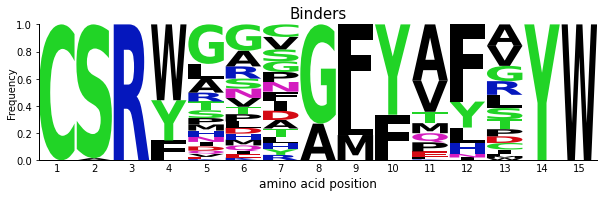

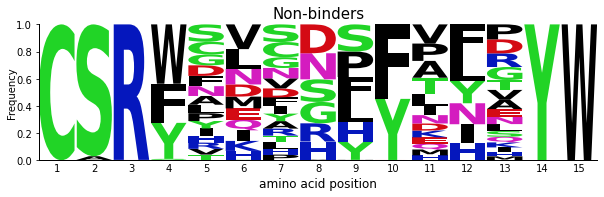

In [15]:
#making sequence logo of binders 
# plt.style.use("seaborn-white")

def sequence_logo_maker(df_freq, title):

  crp_logo = logomaker.Logo(df_freq,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold')

  crp_logo.style_spines(visible=False)
  crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
  crp_logo.style_xticks(fmt='%d', anchor=0)

  crp_logo.ax.set_ylabel("Frequency", labelpad=-1)
  crp_logo.ax.xaxis.set_ticks_position('none')

  crp_logo.ax.set_xticklabels(range(1,16,1))
  crp_logo.ax.xaxis.set_tick_params(pad=-1)
  crp_logo.ax.set_title(title, fontsize = 15)
  crp_logo.ax.set_xlabel("amino acid position", fontsize = 12)

sequence_logo_maker(df_freq_bd, "Binders")
sequence_logo_maker(df_freq_nbd, "Non-binders")



In [ ]:
#sequence distance and clustering! distance embedding 
# do this later

In [16]:
df_sequence_bd["label"] = 1
df_sequence_nbd["label"] = 0
df_data = pd.concat([df_sequence_bd, df_sequence_nbd])

#Feature engineering

key is how to represent sequence data: challenges

1. reasonable, numeric machine-readable representation 
2. reflects the AA diversity 
3. maintain positions 

different appraoches:
1. sequence perspective: NLP approach


2. amino acid-based positional one-hot encoding: 2D features



In [ ]:
#one-hot encoding
aa_list = ['G', 'A', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H',
           'R', 'N', 'D', 'T']



enc = OneHotEncoder(handle_unknown='ignore')
X = np.array(aa_list).reshape(-1,1)
enc.fit(X)
OneHotEncoder(handle_unknown='ignore')
enc.categories_

def sequence_encoder(sequence):
    sequence_2D  = np.array([enc.transform(np.array([i]).reshape(1,-1)).toarray() for i in sequence]).squeeze().tolist()
    return sequence_2D




In [ ]:
#pretty slow
df_data["Sequence_2D"] = df_data.copy().apply(lambda row: sequence_encoder(row.name), axis = 1)
df_data["Sequence_1D"] = [i[0] for i in df_data["Sequence_2D"]]

In [ ]:
# df_data.to_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/training_data.txt", sep = "\t")

In [ ]:
#split the data into training and val set

X = np.array([np.array(x).reshape(15,20) for x in df_data["Sequence_2D"]])
enc_label = LabelEncoder()
y = df_data["label"]
enc_label.fit(y)

y = enc_label.transform(np.array(y).reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=42,
                                                  stratify = y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#ML: LSTM, CNN, random forest, transformer 
model representation? 
- NLP appraoch: language model: LSTM, BERT,
- sequence feature approach : random forest...? SVM
- one-hot encoding appraoch : CNN 


#Machine learning model - CNN


In [ ]:
#Performance 

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [ ]:
#Vannila CNN


# x_input = Input(shape=(15, 20))
vanilla_CNN = Sequential()
#add model layers
vanilla_CNN.add(Conv1D(128, kernel_size=3, input_shape=(15,20)))
vanilla_CNN.add(MaxPooling1D(3))
vanilla_CNN.add(Conv1D(64, kernel_size=3, activation="relu"))
vanilla_CNN.add(Flatten())
vanilla_CNN.add(Dropout(0.25))
vanilla_CNN.add(Dense(32, activation = "relu"))
vanilla_CNN.add(Dense(1, activation="sigmoid"))

vanilla_CNN.compile(optimizer="SGD", loss='binary_crossentropy',
                  metrics=['accuracy', f1])

vanilla_CNN.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 13, 128)           7808      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2, 64)             24640     
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode= "max", patience=30, verbose=1)
mc = ModelCheckpoint('/content/gdrive/My Drive/case_study/deepCDR/clf_best_model_vCNN.h5', 
                     monitor='val_accuracy', mode='max')

history_cnn = vanilla_CNN.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es, mc]
    )

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

In [ ]:
vanilla_CNN.load_weights('/content/gdrive/My Drive/case_study/deepCDR/clf_best_model_vCNN.h5')
display_model_score(vanilla_CNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test],
    32)

138/138 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9846 - f1: 0.9845
Train loss:  0.06040746346116066
Train accuracy:  0.9845700263977051
----------------------------------------------------------------------
46/46 [==============================] - 0s 2ms/step - loss: 0.1148 - accuracy: 0.9660 - f1: 0.9655
Val loss:  0.11476762592792511
Val accuracy:  0.9659632444381714
----------------------------------------------------------------------
46/46 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.9639 - f1: 0.9642
Test loss:  0.10950228571891785
Test accuracy:  0.9639210104942322


In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

#Res-CNN

In [ ]:
x_input = Input(shape=(15, 20))

#initial conv
conv = Conv1D(128, 3, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.25)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_CNN = Model(inputs=x_input, outputs=x_output)
model_CNN.compile(optimizer="SGD", loss='binary_crossentropy',
                  metrics=['accuracy', f1])

model_CNN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15, 20)]     0                                            
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 15, 128)      7808        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 15, 128)      512         conv1d_23[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 15, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
mc = ModelCheckpoint('/content/gdrive/My Drive/case_study/deepCDR/clf_best_model_resCNN.h5', 
                     monitor='val_accuracy', mode='max')
history1 = model_CNN.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es, mc]
    )

Epoch 1/50
138/138 [==============================] - 7s 28ms/step - loss: 0.9841 - accuracy: 0.7791 - f1: 0.7563 - val_loss: 1.0351 - val_accuracy: 0.8761 - val_f1: 0.8842
Epoch 2/50
138/138 [==============================] - 3s 21ms/step - loss: 0.6529 - accuracy: 0.9575 - f1: 0.9578 - val_loss: 0.8078 - val_accuracy: 0.9449 - val_f1: 0.9451
Epoch 3/50
138/138 [==============================] - 3s 21ms/step - loss: 0.6212 - accuracy: 0.9647 - f1: 0.9649 - val_loss: 0.6653 - val_accuracy: 0.9523 - val_f1: 0.9520
Epoch 4/50
138/138 [==============================] - 3s 21ms/step - loss: 0.5980 - accuracy: 0.9738 - f1: 0.9740 - val_loss: 0.6421 - val_accuracy: 0.9564 - val_f1: 0.9558
Epoch 5/50
138/138 [==============================] - 3s 21ms/step - loss: 0.5885 - accuracy: 0.9720 - f1: 0.9719 - val_loss: 0.6517 - val_accuracy: 0.9537 - val_f1: 0.9538
Epoch 6/50
138/138 [==============================] - 3s 21ms/step - loss: 0.5798 - accuracy: 0.9747 - f1: 0.9732 - val_loss: 0.6328 - 

In [ ]:
model_CNN.save_weights('/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr_model_resCNN.h5')

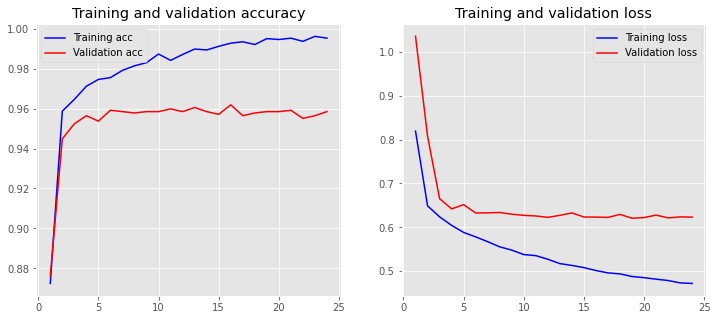

In [ ]:
plot_history(history1)

In [ ]:
display_model_score(model_CNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test],
    32)

138/138 [==============================] - 1s 6ms/step - loss: 0.4647 - accuracy: 0.9977 - f1: 0.9978
Train loss:  0.46470990777015686
Train accuracy:  0.9977309107780457
----------------------------------------------------------------------
46/46 [==============================] - 0s 6ms/step - loss: 0.6234 - accuracy: 0.9585 - f1: 0.9575
Val loss:  0.6233783960342407
Val accuracy:  0.9584751725196838
----------------------------------------------------------------------
46/46 [==============================] - 0s 6ms/step - loss: 0.6104 - accuracy: 0.9619 - f1: 0.9623
Test loss:  0.610435962677002
Test accuracy:  0.9618788361549377


In [ ]:
df_ex_test["Sequence_2D"] = df_ex_test.copy().apply(lambda row: sequence_encoder(row.name), axis = 1)
df_ex_test["Sequence_1D"] = [i[0] for i in df_ex_test["Sequence_2D"]]

In [ ]:
X_ex_test = np.array([np.array(x).reshape(15,20) for x in df_ex_test["Sequence_2D"]])

In [ ]:
y_pred = model_CNN.predict(X_ex_test, batch_size = 32)
y_pred_label = [1 if i >0.5 else 0 for i in y_pred.flatten()]

In [ ]:
df_ex_test["predicted_label"] = y_pred_label
df_predcited = df_ex_test.drop(columns = ["Sequence_2D", "Sequence_1D"])
df_predcited.to_csv("/content/gdrive/My Drive/case_study/deepCDR/case_study_deepcdr/task1_predicted.csv")

In [ ]:
# df_sequence_bd.to_csv("/content/gdrive/My Drive/case_study/deepCDR/sequencing_binding_clean.csv",
#                       sep = "\t")